In [1]:
%matplotlib inline

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew
import seaborn as sns
from sklearn.linear_model import Lasso

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

## Correlation plot

<AxesSubplot:>

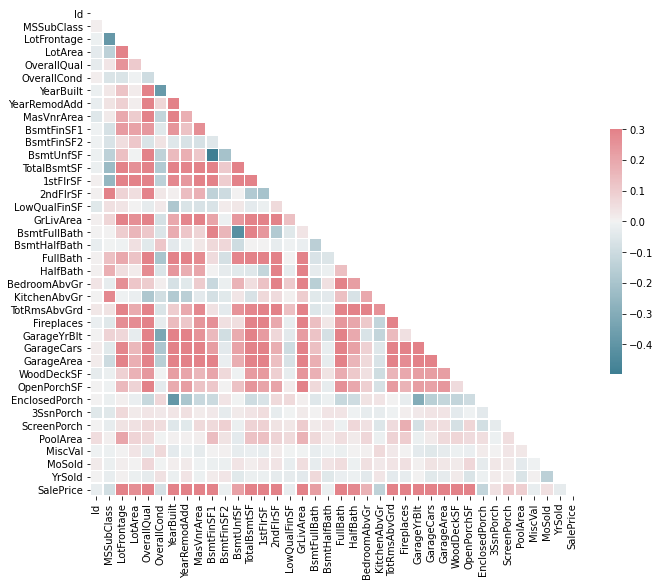

In [4]:
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Using that correlation plot we can find which variables are more important for the price prediction
### We can also use it to drop features and avoid multicollinearity, this improves the accuracy of the model

## Train the model

In [5]:
# remove outliers

train = train[~((train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000))]

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

# drop some features to avoid multicollinearity
all_data.drop(['1stFlrSF', 'GarageArea', 'TotRmsAbvGrd'], axis=1, inplace=True)

train["SalePrice"] = np.log1p(train["SalePrice"])

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.65]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

all_data = all_data.fillna(all_data.mean())

X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [6]:
model = Lasso(alpha=0.0004)
model.fit(X_train, y)

Lasso(alpha=0.0004)

In [7]:
preds = np.expm1(model.predict(X_test))
preds

array([116501.65399964, 155319.70097558, 183102.3177919 , ...,
       171035.10401667, 118574.92050646, 224184.07894395])

In [8]:
pickle.dump(model, open("data/model.pickle", "wb"))